In [1]:
#URL: https://d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html
#seq2seq
#
# Setup env
!pip install d2l==1.0.0b0
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gym
  Running setup.py clean 

In [2]:
import os
import torch
from d2l import torch as d2l
import os
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Building dataset for seq 2 seq learning
https://d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html

In [3]:
#Download and preprocess data
class MTFraEng(d2l.DataModule):
    def __init__(self, batch_size, num_steps = 9, num_train = 512, num_val = 128):
      super().__init__()
      self.save_hyperparameters()

      #Data set format: 
      #http://www.manythings.org/anki/
      #<english sentence> <french sentence>
      # tab is delimiter
      #build the arrays, src_vocab, and target_vocab
      self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(self._download())

    """The English-French dataset."""
    def _download(self):

        data_path = self.root + '/fra-eng/fra.txt'
        if not os.path.exists(data_path):
          print("download data to ", self.root)
          d2l.extract(d2l.download(d2l.DATA_URL+'fra-eng.zip', self.root,'94646ad1522d915e7b0f9296181140edcf86a4f5'))
        print('opening dataset ...')
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

    def _preprocess(self, text):
      # Replace non-breaking space with space
      text = text.replace('\u202f', ' ').replace('\xa0', ' ')
      # Insert space between words and punctuation marks
      no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
      out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
            for i, char in enumerate(text.lower())]
      return ''.join(out)
    
    def _tokenize(self,text, max_samples = None):
      #produce each individual words
      # like sentence 'hello world' --> ['how', 'world', <eos>]
      src, tgt = [],[]
      for i, line in enumerate(text.split('\n')):
        if max_samples and i > max_samples: break

        #append <eos> to every end of sequence
        parts = line.split('\t')
        if len(parts) == 2:
          #ignore empty tokens
          src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
          tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])

      return src, tgt

    def _build_arrays(self, raw_text, src_vocab = None, tgt_vocab = None):
      def _build_array(sentences, vocab, is_tgt = False):
        #pad or trim of sequence length is smaller or larger than t
        pad_or_trim = lambda seq, t: (seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))

        #build the sentences, pad of trim based on num_steps
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]

        #add <bos> to every sentence if target vocab. For teacher forcing method in decoder 
        if is_tgt:
          sentences = [['<bos>'] + s for s in sentences]

        #Build a vocab and ignore words with frequency less than 2
        if vocab == None:
          vocab = d2l.Vocab(sentences, min_freq = 2)
      
        v = [vocab[s] for s in sentences]
        #build training data
        array = torch.tensor([vocab[s] for s in sentences])
        # calculate the length which is valid in array
        # like [word1, word2, word3, <pad>, <pad>, <pad>] then valid len = 3
        valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)

        return array, vocab, valid_len
      
      src, tgt = self._tokenize(self._preprocess(raw_text), self.num_train + self.num_val)
      src_arr, src_vocab, src_valid_len = _build_array(src, src_vocab)
      tgt_arr, tgt_vocab, tgt_valid_len = _build_array(tgt, tgt_vocab, True)

      return ((src_arr, tgt_arr[:, :-1], src_valid_len, tgt_arr[:, 1:]),src_vocab, tgt_vocab)

    def get_dataloader(self, train):
      #if train, slice to self.num_train, if for valid, slice from num_train to end
      idx = slice(0, self.num_train) if train else slice(self.num_train, None)
      return self.get_tensorloader(self.arrays, train, idx)

    def build(self, src_sent, tgt_sent):
      raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(src_sent, tgt_sent)])
      arrays, _, _ = self._build_arrays(raw_text, self.src_vocab, self.tgt_vocab)
      return arrays
  
        
data = MTFraEng(batch_size = 3)



download data to  ../data
opening dataset ...


In [4]:

src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print('source:', src.type(torch.int32))
print('decoder input:', tgt.type(torch.int32))
print('source len excluding pad:', src_valid_len.type(torch.int32))
print('label:', label.type(torch.int32))

src,tgt, _, _ = data.build(['hi. '], ['salut. '])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: tensor([[144, 174,   0,   3,   4,   4,   4,   4,   4],
        [ 84, 152,   2,   3,   4,   4,   4,   4,   4],
        [ 84, 141,   2,   3,   4,   4,   4,   4,   4]], dtype=torch.int32)
decoder input: tensor([[  3,  87,   0,   4,   5,   5,   5,   5,   5],
        [  3, 108, 183,   6,   2,   4,   5,   5,   5],
        [  3, 108,   6,   2,   4,   5,   5,   5,   5]], dtype=torch.int32)
source len excluding pad: tensor([4, 4, 4], dtype=torch.int32)
label: tensor([[ 87,   0,   4,   5,   5,   5,   5,   5,   5],
        [108, 183,   6,   2,   4,   5,   5,   5,   5],
        [108,   6,   2,   4,   5,   5,   5,   5,   5]], dtype=torch.int32)
source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [5]:
#sample for tokenization method
a = "Did he go there?	S'y est-il rendu ?"
a = a.split('\t')
b = [t for t in f'{a[0]} <eos>'.split(' ') if t]
c = [t for t in f'{a[1]} <eos>'.split(' ') if t]

print(b)
print(c)

['Did', 'he', 'go', 'there?', '<eos>']
["S'y", 'est-il', 'rendu', '?', '<eos>']


# Encoder
- Transforms hidden state from previous hidden state H_t-1 and current token X_t

- Then transforms into context variable using all hidden states



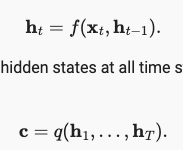

In [6]:
#The encoder-decoder architecture

#init weights for encoder decoder
def init_weights(module):
  if type(module) == nn.Linear:
    nn.init.xavier_uniform_(module.weight)
  
  if type(module) == nn.GRU:
    for param in module._flat_weights_names:
      if "weight" in param:
        nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):
  def __init__(self, vocab_size, embed_size,num_hiddens, num_layers,dropout=0):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
    self.apply(init_weights)

  def forward(self, X, *args):
    # X shape (batch_size, num_steps)
    # embs shape (num_steps, batch_size, embed_size)
    embs = self.embedding(X.t().type(torch.int64))
    # output shape (num_steps, batch_size, embed_size)
    # state shape (num_layers, batch_size, num_hiddens)
    outputs, state = self.rnn(embs)
    return outputs, state    

#Test run
vocab_size, embed_size, num_hiddens, num_layers, batch_size, num_steps =\
 10, 8, 16, 2, 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
#(batch_size, num_steps)
print('X shape = ', X.shape)
outputs, state = encoder(X)
#(num_layers, batch_size, num_hiddens)
print('state shape = ', state.shape)
#(num_steps, batch_size, num_hiddens)
print('output shape = ', outputs.shape)

X shape =  torch.Size([4, 9])
state shape =  torch.Size([2, 4, 16])
output shape =  torch.Size([9, 4, 16])


## Transformation of Decoder's layer

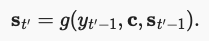

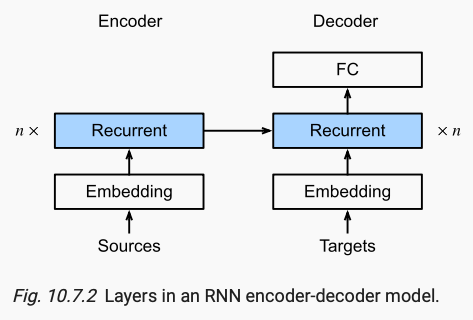

In [7]:

class Seq2SeqDecoder(d2l.Decoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    #the context variable is concatenated with the decoder input at all the time steps
    self.rnn = d2l.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout)
    #softmax layer to predict probability of Y_t'+1
    self.dense = nn.LazyLinear(vocab_size)
    self.apply(init_weights)

  def init_state(self, enc_all_ouputs, *args):
    return enc_all_ouputs

  # hidden state at the final time step
  def forward(self, X, state):
    # X shape = (batch_size, num_steps)
    #embs_shape = (num_steps, batch_size, embed_size)
    embs = self.embedding(X.t().type(torch.int32))
    enc_output, hidden_state = state
    #last output from encoder will be used as context
    #context variable shape ( batch_size, num_hiddens)
    context = enc_output[-1]
    #context variable is concatenated to all inputs to decoder, 
    #so we repeat and broadcast it
    #broadcast context to (num_steps, batch_size, num_hiddens)
    context = context.repeat(embs.shape[0], 1, 1)
    #concat at feature dimension
    embs_and_context = torch.cat((embs, context), -1)
    outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
    #output shape: (batch_size, num_steps, vocab_size)
    #hiden_state (num_layers, batch_size, num_hiddens)
    outputs = self.dense(outputs).swapaxes(0,1)

    return outputs, [enc_output, hidden_state]

def get_shape(x):
  print(f'{len(x)},{len(x[0])},{len(x[0][0])}')

#same with encoder params
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)

state = decoder.init_state(encoder(X))

decoder_output, state = decoder(X, state)

#state shape
print('decoder state (enc_output, enc_state)')
print('encoder output shape =', state[0].shape)
print('encoder state shape =', state[1].shape)
print('decoder_output shape = ', decoder_output.shape)
    

decoder state (enc_output, enc_state)
encoder output shape = torch.Size([9, 4, 16])
encoder state shape = torch.Size([2, 4, 16])
decoder_output shape =  torch.Size([4, 9, 10])


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Time to train this shit

In [8]:
class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder-decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()
      
    def loss(self, Y_hat, Y):
      l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
      mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
      return (l * mask).sum() / mask.sum()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

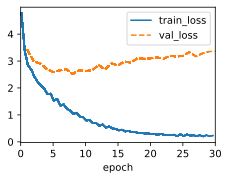

In [9]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [18]:
#BLEU score
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

#Make predictions 
def predict_step(self, batch, num_steps, device, save_attention_weights = False):
  batch = [a.to(device) for a in batch]
  src, tgt, src_valid_len, _ = batch
  enc_all_outputs = self.encoder(src, src_valid_len)
  dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)

  outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []

  for _ in range(num_steps):
    Y, dec_state = self.decoder(outputs[-1], dec_state)
    outputs.append(Y.argmax(2))

    if save_attention_weights:
      attention_weights.append(self.decoder.attention_weights)
    
    return torch.cat(outputs[1:], 1), attention_weights
  
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

src, tgt, _, _ = data.build(engs, fras)
print('src vocab size ', len(data.src_vocab))
print('tgt vocab size ', len(data.tgt_vocab))
#shape of src or tgt = (batch, len(src), max_len)
for i in range(len(src)):
  print(src[i].shape)
  print(src[i])
  print(data.src_vocab.to_tokens(src[0].type(torch.int32)))
  print(tgt[i])
  print(data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))
  print()

preds, _ = model.predict_step(data.build(engs, fras), d2l.try_gpu(), data.num_steps)


src vocab size  194
tgt vocab size  214
torch.Size([9])
tensor([59,  2,  3,  4,  4,  4,  4,  4,  4])
['go', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tensor([  3, 201,   0,   4,   5,   5,   5,   5,   5])
['<bos>', 'va', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

torch.Size([9])
tensor([ 84, 105,   2,   3,   4,   4,   4,   4,   4])
['go', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tensor([  3, 105, 148,   2,   4,   5,   5,   5,   5])
['<bos>', 'va', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

torch.Size([9])
tensor([67, 22,  2,  3,  4,  4,  4,  4,  4])
['go', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tensor([  3, 102,  77,  38,   2,   4,   5,   5,   5])
['<bos>', 'va', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

torch.Size([9])
tensor([86, 76,  2,  3,  4,  4,  4,  4,  4])
['go', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tensor([  3, 108,

In [22]:
print(preds)
for en, fr, p in zip(engs, fras, preds):
  translation = []
  for token in data.tgt_vocab.to_tokens(p):
    if token == '<eos>':
      break
    translation.append(token)
  print(f'{en} => {translation}, bleu={bleu(" ".join(translation), fr, k = 2)}')

tensor([[201,   0,   4,   2,   4,   2,   4,   2,   4],
        [105, 148,   2,   4,   2,   4,   2,   4,   2],
        [102,  77, 131,   2,   4,   2,   4,   2,   4],
        [108, 183,  47, 129,   2,   4,   2,   4,   2]])
go . => ['va', '!'], bleu=1.0
i lost . => ["j'ai", 'perdu', '.'], bleu=1.0
he's calm . => ['il', 'est', 'mouillé', '.'], bleu=0.6580370064762462
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu=1.0
